# Linear Regression, the LASSO and Ridge

Last revision: Thu 2 June 2022 2:32:00 AEST

Author: Omar Ghattas

## Introduction

In this lab we will explore linear models in more depth, specifically:

1. Linear regression and how to run a linear regression model in the Python library `scikit-klearn`, also commonly referred to as `sklearn`. The focus here will be on practical aspects of the modelling, and you should look at the tutorial this week to understand what is going on under the hood. It is important for you to understand both the theory and pratical side of the concepts we cover throughout the course.

2. Regularized linear models, namely the LASSO and Ridge models. 

**Note: this notebook has only been tested using Python 3.**

#### What is `sklearn` ?
Throughout this course, we will be relying heavily on the `sklearn` module which contains implementations of many of the algorithms that will be covered. The following links to a summary of the different types of algorithms available, you will likely need to make use of all of them at some point in the course:

https://scikit-learn.org/stable/

Here is a short summary of what the different sections mean:

1. Classification: contains implementations of classification models such as SVM and Naive Bayes. Classification refers to the case where we have access to data of the form $(x_i, c_i)$, where $x_i$ is a collection of features, and $c_i$ is a class label. For example, in an image classification task, we might have access to images of cats and dogs, and wish to build a classifier that takes as input $x_i$ (a collection of pixels), and predicts the correct class label (0 for cat, 1 for dog). Importantly, the class label is always one of a discrete number of possible choices.

2. Regression: Similar to classification, except that now we have data $(x_i, y_i)$ and $y_i$ is a continuous value. For example, $x_i$ could represent information about a patient (e.g. age, weight, height, blood pressure) and $y_i$ could represent the patients chance of recovering from a particular surgery.

3. Clustering: Both 1. and 2. are examples of supervised learning, since we have access to a label ($c_i$) or target value $(y_i)$. In many cases of interest, we do not have access to a label, we only have access to $x_i$. For example, you have access to 100,000 machine-readable texts. You would like to understand which of the texts are 'similar'. In this case you might employ a clustering algorithm to group similiar texts into the same clusters. If your clustering algorithm is successful, your clusters might correspond to texts written by the same author, or texts of the same genre, etc.

4. Dimensionality reduction: Often the $x_i$ in categories of 1., 2., 3. can be massive. For example, an 3.1 megapixel image is 2048 pixels in width, and 1536 pixels in height, and can be represented as a matrix of pixel values:

$$
x_i = \begin{bmatrix}
p_{1,1}&p_{1,2} &p_{1,3} & \cdots p_{1,2048}\\
p_{2,1}&p_{2,2} &p_{2,3} & \cdots p_{2,2048}\\
\vdots&\vdots &\vdots & \cdots \vdots\\
p_{1536,1}&p_{1536,2} &p_{1536,3} & \cdots p_{1536,2048}\\
\end{bmatrix}
$$

where each element represents the brightness of that particular portion of the image. Note that we therefore have a total of ~3.1 million pixels. In many cases, we don't really believe that we need this many pixels to understand what is contained in the image, and more importantly, it is often difficult to run a machine learning algorithm on such a high dimensional problem in a reasonable amount of time. For example, an image of a dog can be identified by noting that the image contains pointy ears, a tail, and a black nose, and this information might be contained in a collection of 10,000 pixels. It is therefore important to understand how one might reduce an input $x_i \in \mathbb{R}^p$ to some lower dimensional $z_i \in \mathbb{R}^k$, where $k \ll p$, and where $z_i$ retains much of the information contained in $x_i$. This is what the algorithms in this sub-module do.

5. Model Selection: it is important to not only know how to build a model, but also be able to pick the best model out of a collection of models. This sub-module contains algorithms to do just that. It also contains important functions that allow us to perform cross validation to choose hyperparameters, something that will be important to us in future weeks (and for the final project).

6. Preprocessing: Before running a machine learning algorithm, we usually need to perform a fair amount of preprocessing to the original data before. For example, we might wish to scale our feature vectors to be in the range [0,1], or we might want to handle missing data, or generate new features.

You are encouraged to refer to this link regularly. In this lab, we will focus on linear regression, which is contained in the Regression section:

https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

#### Linear Models in `sklearn`

In the following, we will:

1. use `sklearn` to create a toy dataset with a specified number of samples ($n$) and features ($p$)
2. split the data into train and test sets
3. fit a linear regression model, a LASSO model, and a ridge model to the training data. For reference, recall that the three models solve the following different objectives:
- linear model: $\hat{\beta} = \arg \min_{\beta} \frac{1}{n}\|y-X \beta\|^2_2$
- LASSO model: $\hat{\beta}_{\text{LASSO}} = \arg \min_{\beta} \frac{1}{n}\|y-X \beta\|^2_2 + \lambda \| \beta \|_1$
- Ridge model: $\hat{\beta}_{\text{Ridge}} = \arg \min_{\beta} \frac{1}{n}\|y-X \beta\|^2_2 + \alpha \| \beta \|_2^2$
4. Evaluate each of the models on the test data and compare them using various metrics

The MSE term is a `data-fit' term, which measures how well the model fits the data by looking at the distance of the true $y$ values to the predicted values $\hat{y} = X\beta$, and the second term (in LASSO and ridge) is a penalty term that increases as the length of the solution increases. Length is a proxy for the complexity of the model, and so we can think of this term as preferring simpler models to more complex ones. LASSO and Ridge therefore represent a trade-off: on the one hand they would like to get a perfect fit and reduce the first term to zero, but this can only really be done with very complex models that will lead the penalty term to become very large. Note also that $\alpha$ and $\lambda$ are known as hyper-parameters, whereas we generally refer to $\beta$ as the unknown parameter, or weights of the model.

Throughout, pay close attention to which sub-modules are being used, and check out the `sklearn` documentation which is often an excellent reference. Also note that we are fitting the most basic form of each model, and you should dig deeper to understand the different arguments available.

In [17]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt

In [18]:
# set a random seed for reproducibility
rs = np.random.RandomState(123)

# create a dataset of X, y pairs
n = 1000                   # number of samples
p = 10                     # number of features
noise = 0.4                # add noise to the data
nmb_informative=p//2       # how many of the p feature are actually useful for prediction
X, y = make_regression(n, p,
                       noise=noise,
                       n_informative=nmb_informative,
                       random_state=rs)

# split into training data and test data
train_prop = 0.7           # proportion of data in train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rs)

# fit models to train data
m_linearReg = LinearRegression().fit(X_train, y_train)
m_lasso = Lasso().fit(X_train, y_train)
m_ridge = Ridge().fit(X_train, y_train)

# compute predictions of each model on the train data
ypred_train_linearReg = m_linearReg.predict(X_train)
ypred_train_lasso = m_lasso.predict(X_train)
ypred_train_ridge = m_ridge.predict(X_train)

# compute predictions of each model on the test data
ypred_test_linearReg = m_linearReg.predict(X_test)
ypred_test_lasso = m_lasso.predict(X_test)
ypred_test_ridge = m_ridge.predict(X_test)

Note that the `sklearn` implementations all have the same methods, so understanding how the `linearRegression` implementation works means you pretty much understand how any other regression algorithm in `sklearn` works too. 

Now, we have fit various models, and wish to evaluate them. We can use a pandas dataframe to make this look nice:

In [19]:
import pandas as pd

# first compute metrics and store them in array
loss_data = [
    ['linear regression',
     mean_squared_error(y_train, ypred_train_linearReg),
     mean_squared_error(y_test, ypred_test_linearReg),
     mean_absolute_error(y_train, ypred_train_linearReg),
     mean_absolute_error(y_test, ypred_test_linearReg)
    ],
    ['lasso',
     mean_squared_error(y_train, ypred_train_lasso),
     mean_squared_error(y_test, ypred_test_lasso),
     mean_absolute_error(y_train, ypred_train_lasso),
     mean_absolute_error(y_test, ypred_test_lasso)
    ],
    ['ridge',
     mean_squared_error(y_train, ypred_train_ridge),
     mean_squared_error(y_test, ypred_test_ridge),
     mean_absolute_error(y_train, ypred_train_ridge),
     mean_absolute_error(y_test, ypred_test_ridge)
    ]
]

# create a pandas dataframe and feed it the array and naming the columns
loss_df = pd.DataFrame(loss_data,
                       columns=['Model', 'train MSE', 'test MSE', 'train MAE', 'test MAE'])
print(loss_df)

               Model  train MSE  test MSE  train MAE  test MAE
0  linear regression   0.151018  0.176519   0.312670  0.334087
1              lasso   4.907329  4.128131   1.795599  1.637552
2              ridge   0.189097  0.193945   0.353909  0.351923


 <font color='purple'>

#### Exercise:

Can you think of a good reason why the lasso performs so poorly in this scenario? Hint: hyperparameters

 <!-- <font color='green'> -->
Recall that the lasso has an extra parameter, $\lambda$. When we ran the lasso regression we didn't specify a value and so `sklearn` chose the default value of $\lambda=1$, which seems to have been a terrible choice for this particular problem. One can specify a specific value of $\lambda=0.1$ for example by running

`Lasso(alpha=0.1)`

One way to (algorithmically) choose a better $\lambda$ is to perform cross validation, which we will explore in more depth a little later in the lab. For now, we note that sklearn has an in built object that does LASSO regression that automatically performs cross validation for the choice of $\lambda$, called `LassoCV` - note that there is also a `RidgeCV` object available. Choosing $\lambda$ properly should make a big difference in our results. We use it as follows:

In [20]:
from sklearn.linear_model import LassoCV

m_lassoCV = LassoCV().fit(X_train, y_train)                 # automatically perform CV for choice of lambda
ypred_train_lassoCV = m_lassoCV.predict(X_train)
ypred_test_lassoCV = m_lassoCV.predict(X_test)

# add row to loss_df
lassoCV_row = {'Model': 'lasso CV',
               'train MSE': mean_squared_error(y_train, ypred_train_lassoCV),
               'test MSE': mean_squared_error(y_test, ypred_test_lassoCV),
               'train MAE': mean_absolute_error(y_train, ypred_train_lassoCV),
               'test MAE' :mean_absolute_error(y_test, ypred_test_lassoCV)}

loss_df.append(lassoCV_row, ignore_index=True)

,Model,train MSE,test MSE,train MAE,test MAE
0,linear regression,0.151018,0.176519,0.312670,0.334087
1,lasso,4.907329,4.128131,1.795599,1.637552
2,ridge,0.189097,0.193945,0.353909,0.351923
3,lasso CV,0.203116,0.208579,0.365991,0.362380


Let's take a minute to inspect our fitted linear model object. Recall that a linear model just minimizes an objective:
$$
\hat{\beta} = \arg \min_{\beta} = \frac{1}{n} \| y-X\beta\|^2_2
$$
If we want to access the estimate computed, i.e. the value of $\hat{\beta}$, we can do so by running


- $\hat{\beta}_0 \leftrightarrow$ `m_linearReg.intercept_`
- $[\hat{\beta}_1, \hat{\beta}_2, \dots, \hat{\beta}_p ] \leftrightarrow$ `m_linearReg.coef_`


### What's in a feature?
In this section, let's investigate how choosing the wrong features can impact the performance of our model. We will work with a single feature in this case. We will specify a "true" function $f(x)=x^2$, and then create a `data generating process' which will let us sample noisy observations from $f$. We do this by sampling:

$$
y = f(x) + \epsilon, \qquad \epsilon \sim N(0, \sigma^2).
$$

In other words, each observation $y$ in our dataset is $f$ evaluated at the point $x$, plus some random Gaussian noise. We will first generate $n$ data points in this way, and then try to fit a model to the resulting dataset. We will fit two models:

1. bad model: $\hat{y} = b_0 + b_1 x$
1. good model: $\tilde{y} = w_0 + w_1 x^2$

We call the first model a bad model since we know that the true underlying function is the square function, but we are only including $x$ in our model. The second model is the good model because it uses the correct feature. We will work with a single feature so that we can easily visualise the different model fits.

In [35]:
n = 40
X = np.random.uniform(-1, 1, size=(n,1))          # generate 100 points uniformly on [-1,1] and shape into column
noise = np.random.normal(0, 0.2, size=(n,1))      # generate 100 noise variables with sigma=0.2
f = lambda x: x**2                                # true function f(x) = x^2
y = f(X) + noise                                  # noisy observations

bad_mod = LinearRegression().fit(X, y)
good_mod = LinearRegression().fit(np.concatenate((X,X**2), axis=1), y)

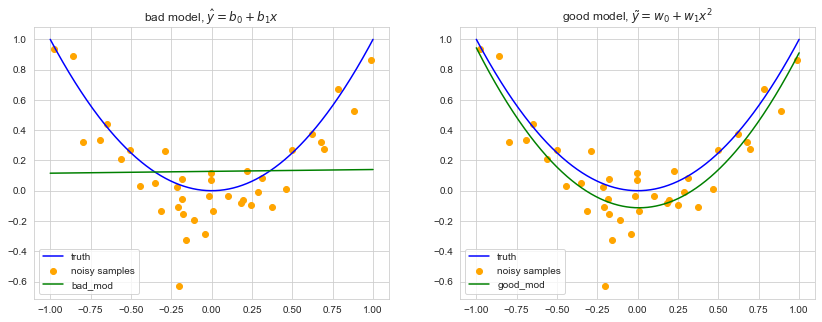

In [39]:
# visualization code - see intro lab for more details on plotting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
xrange = np.linspace(-1,1,1000)

# first axis
ax1.plot(xrange, f(xrange), color='blue', label='truth')
ax1.scatter(X, y, color='orange', label='noisy samples')

# create function for bad_mod
bad_lr = lambda x: bad_mod.intercept_[0] + bad_mod.coef_[0][0]*x

ax1.plot(xrange, bad_lr(xrange), color='green', label='bad_mod')
ax1.legend()
ax1.set_title("bad model, $\hat{y} = b_0 + b_1 x$")

# second axis
ax2.plot(xrange, f(xrange), color='blue', label='truth')
ax2.scatter(X, y, color='orange', label='noisy samples')
# create function for good_mod
good_lr = lambda x: good_mod.intercept_[0] + good_mod.coef_[0][0]*x + good_mod.coef_[0][1]*x**2
ax2.plot(xrange, good_lr(xrange), color='green', label='good_mod')
ax2.legend()
ax2.set_title("good model, $\\tilde{y} = w_0 + w_1 x^2$")

plt.show()

From the above exercise, we can see that it is absolutely crucial to think about what features to include in your model.

 <font color='purple'>

#### Exercise:
    
Repeat the above experiment with a different true function, plot the results and compute the MSE between the bad and good models

### Exploring a real dataset
We now look at a real-life dataset contained in `life_expectancy.csv` and introduce some techniques for data exploration. Data exploration is important for identifying both model and possible features to include in your model. In the previous example, we knew exactly what the 'true' model was, but in reality we only have access to the data and must somehow use this data to learn a good estimate of the truth. The following is a rough guide for what should be done with real data and you should expand on these techniques throughout the course (especially in your group projects).

Data summary: the 9 features in the dataset represent Infant deaths, Alcohol, Percentage expenditure, Hepatitis B, Measles, BMI, Total expenditure, Population and Schooling. The target of interest is Life expectancy. There are a total of 500 records.

Let's read in the data and generate a few exploratory plots. Usually we are looking to understand:

1. The distribution of the target variable and the explanatory variables (the features)
2. Are there any noticeable outliers?
3. What is the relationship between the target variable and the features? If it is linear, then a linear model is a good choice for example.

This process is usually called the 'Exploratory Data Analysis (EDA)' stage. We will plot using the `seabord` module which produces some nice plots easily when working with pandas dataframes, but all of these plots can be created using matplotlib of course.

In [41]:
import seaborn as sns
le_df = pd.read_csv("life_expectancy.csv")         # loading in data using pandas

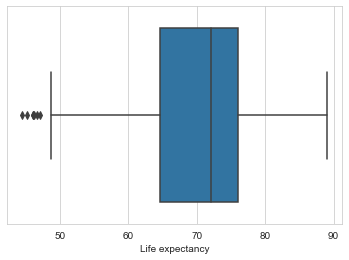

In [42]:
sns.boxplot(x=le_df['Life expectancy'])            # inspecting distribution of target variable using a boxplot
plt.show()

Next, we look at the correlations between the target variable (Life expectancy) and the other variables. If features are highly correlated (either positively or ngetaively) then they should be good additions to the model. Note however that these correlations only capture linear correlations, and it is possible for two variables to be related even if their correlation is zero. See here for some nice examples:

https://blog.revolutionanalytics.com/2017/05/the-datasaurus-dozen.html

Note that a correlation matrix is symmetric, so elements above the diagonal are identical to those below the diagonal. For this reason we only need to view the lower triangular portion of the matrix.

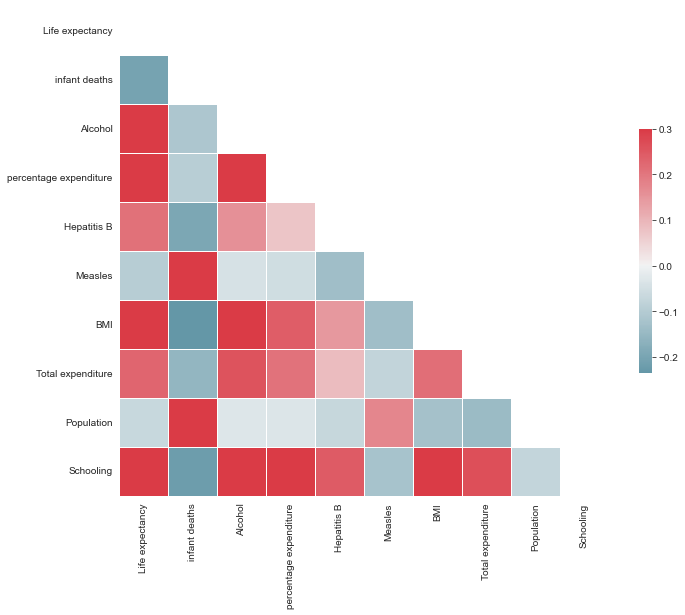

In [25]:
corr_mat = le_df.corr()                               # compute the correlation matrix

mask = np.zeros_like(corr_mat, dtype=bool)            # mask out upper triangle (correlation matrices are symmetric)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)   # generate custom colormap
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [44]:
corr_mat = le_df.corr()

corr_mat

,Life expectancy,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,Total expenditure,Population,Schooling
Life expectancy,1.000000,-0.204407,0.475003,0.420296,0.209747,-0.097254,0.564555,0.228552,-0.068723,0.758401
infant deaths,-0.204407,1.000000,-0.112800,-0.094383,-0.194099,0.519711,-0.235572,-0.155692,0.494219,-0.220832
Alcohol,0.475003,-0.112800,1.000000,0.442561,0.158673,-0.043559,0.364491,0.256207,-0.032005,0.637569
percentage expenditure,0.420296,-0.094383,0.442561,1.000000,0.073738,-0.055402,0.241808,0.207035,-0.033014,0.402481
Hepatitis B,0.209747,-0.194099,0.158673,0.073738,1.000000,-0.134669,0.146348,0.088275,-0.070949,0.244080
Measles,-0.097254,0.519711,-0.043559,-0.055402,-0.134669,1.000000,-0.133289,-0.078202,0.172856,-0.121842
BMI,0.564555,-0.235572,0.364491,0.241808,0.146348,-0.133289,1.000000,0.213709,-0.128128,0.554953
Total expenditure,0.228552,-0.155692,0.256207,0.207035,0.088275,-0.078202,0.213709,1.000000,-0.141729,0.265447
Population,-0.068723,0.494219,-0.032005,-0.033014,-0.070949,0.172856,-0.128128,-0.141729,1.000000,-0.074889
Schooling,0.758401,-0.220832,0.637569,0.402481,0.244080,-0.121842,0.554953,0.265447,-0.074889,1.000000


Another important type of plot is the pair plot, which plots a scatter of each variable against every other variable. Note that the diagonals contain histograms of each variable. We usually want to look for variables that seem to be related based on their scatters.

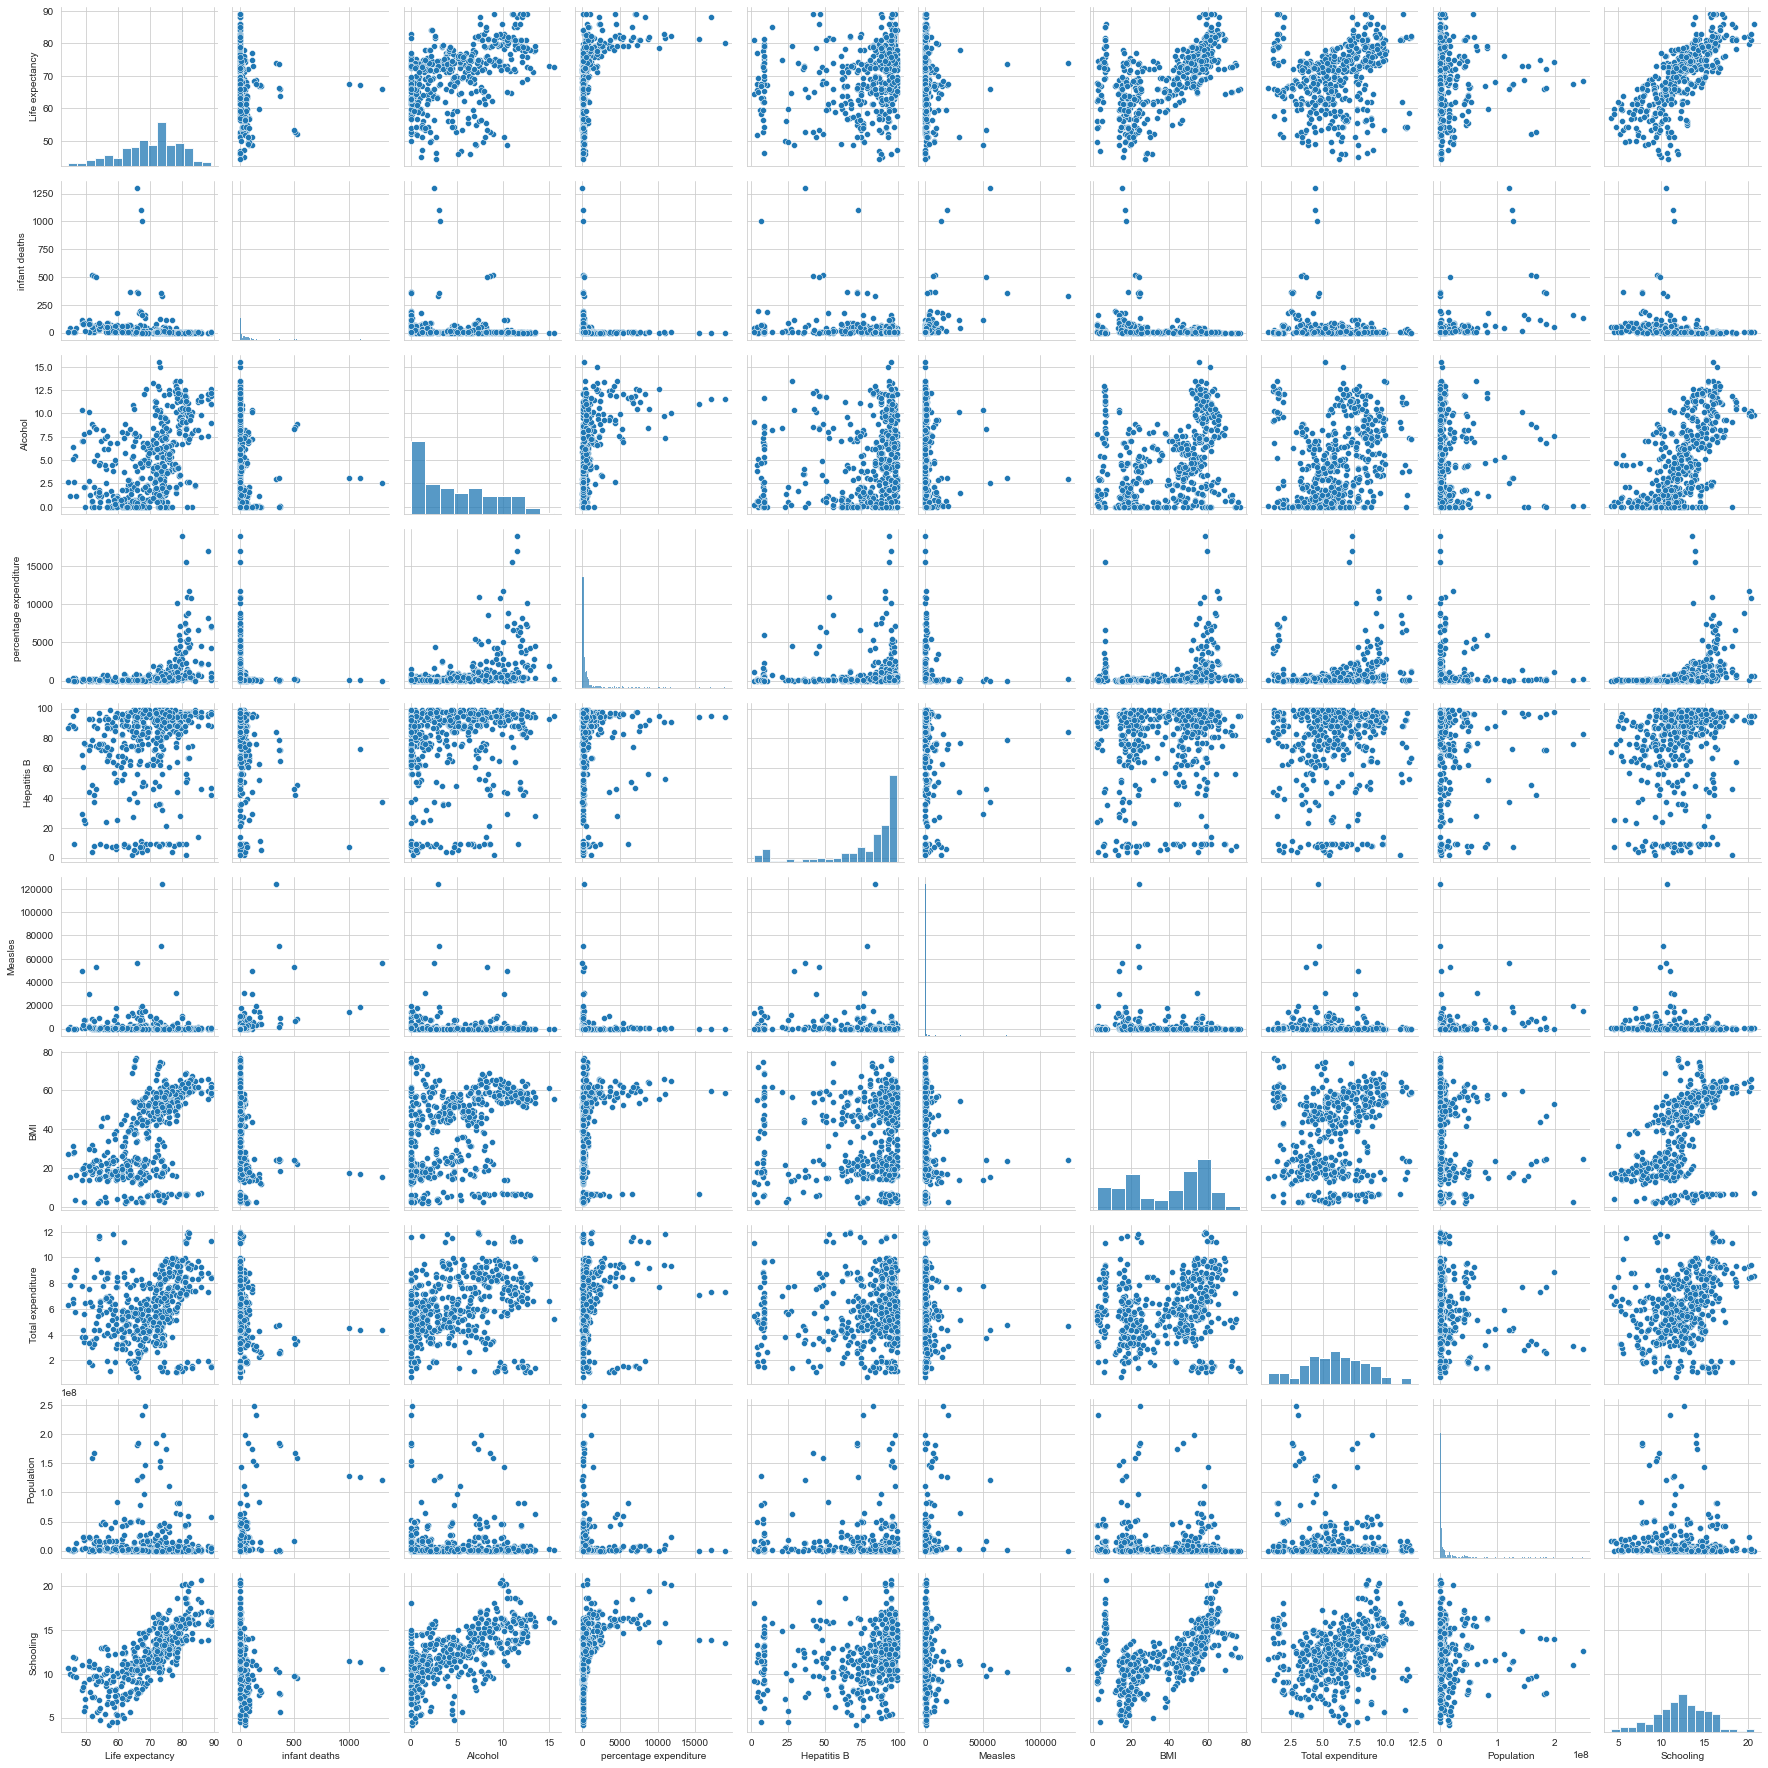

In [45]:
sns.pairplot(le_df)
plt.show()

 <font color='purple'>

#### Extended Exercise: LASSO vs. Ridge
In this exercise, we will explore the differences between LASSO and Ridge regression models, and we will take a deep look at cross validation and how it works for choosing hyper-parameters for these models. You need to do the following:

Q1. Consider the dataset: `data.csv`, with response $Y$ and features $X_1,\dots, X_8$. Create a pairs plot to study the correlations between the features. Describe what you see and how this might affect a linear regression model.

Q2. In order for LASSO and Ridge to be run properly, we often rescale the features in the dataset. Explain Why. Then, use the `sklearn.preprocessing.StandardScaler` function to scale your features. Print out the mean and variance of each of the 8 features (after they have been scaled).

Q3. Now we will apply ridge regression to this dataset, recall that ridge regression is defined as the solution to the optimisation:
    \begin{align*}
        \hat{\beta} = \arg\min \left \{ \frac{1}{2}\|Y-X\beta \|^2_2 + \lambda \| \beta\|_2^2\right \}.
    \end{align*}
    Run ridge regression with $\lambda = \{0.01,0.1,0.5,1,1.5, 2,5,10, 20, 30,50, 100, 200, 300\}$. Create a plot with $x$-axis representing $\log(\lambda)$, and $y$-axis representing the value of the coefficient for each feature in each of the fitted ridge models. In other words, the plot should describe what happens to each of the coefficients in your model for the different choices of $\lambda$. For this problem you are permitted to use the \texttt{sklearn} implementation of Ridge regressiom to run the models and extract the coefficients, and base matplotlib/numpy to create the plots but no other packages are to be used to generate this plot. In a few lines, comment on what you see, in particular what do you observe for features $3, 4, 5$?
    
Q4. Now, use Leave-One-Out Cross Validation (LOOCV) to find a good value of $\lambda$ for the ridge problem. Create a  grid of $\lambda$ values running from $0$ to $50$ in increments of $0.1$, so the grid would be: $0, 0.1, 0.2,\dots, 50$. For each data point $i=1,\dots, n$, run ridge with each $\lambda$ value on the dataset with point $i$ removed, find $\hat{\beta}$, then get the leave-one-out error for predicting $Y_i$. Average the squared error over all $n$ choices of $i$. Plot the leave-one-out error against $\lambda$ and find the best $\lambda$ value. Compare your results to standard Ordinary Least Squares (OLS), does the ridge seem to give better prediction error based on your analysis? Note that for this question you are \textbf{not} permitted to use any existing packages that implement cross validation, you must write the code yourself from scratch. You must create the plot yourself from scratch using basic matplotlib functionality.

Q5. Repeat Q3 but for the LASSO

Q6. Repeat Q4 but for the LASSO

Q7. Comment on what you observe and which model you would prefer in a prediction problem. What about an inference problem?

 <font color='green'>

#### Q1
From the pairs plot, we can see an almost perfect correlation between X3, X4 and X5. In general, there is a large amount of multicollinearity in the dataset. Including all of the variables into the model will introduce multicollinearity in to the regression, which may cause issues such as not being able to compute the MLE estimate of $\beta$ since
        the data matrix may be rank deficient and so $X^T X$ may not be invertible. Further issues would be that interpretation of the regression coefficients for each of the predictors would not be as accurate as in the non-collinear case, since we cannot hold any one variable constant whilst changing the other. We might also expect to see larger standard error estimates for the regression coefficients.

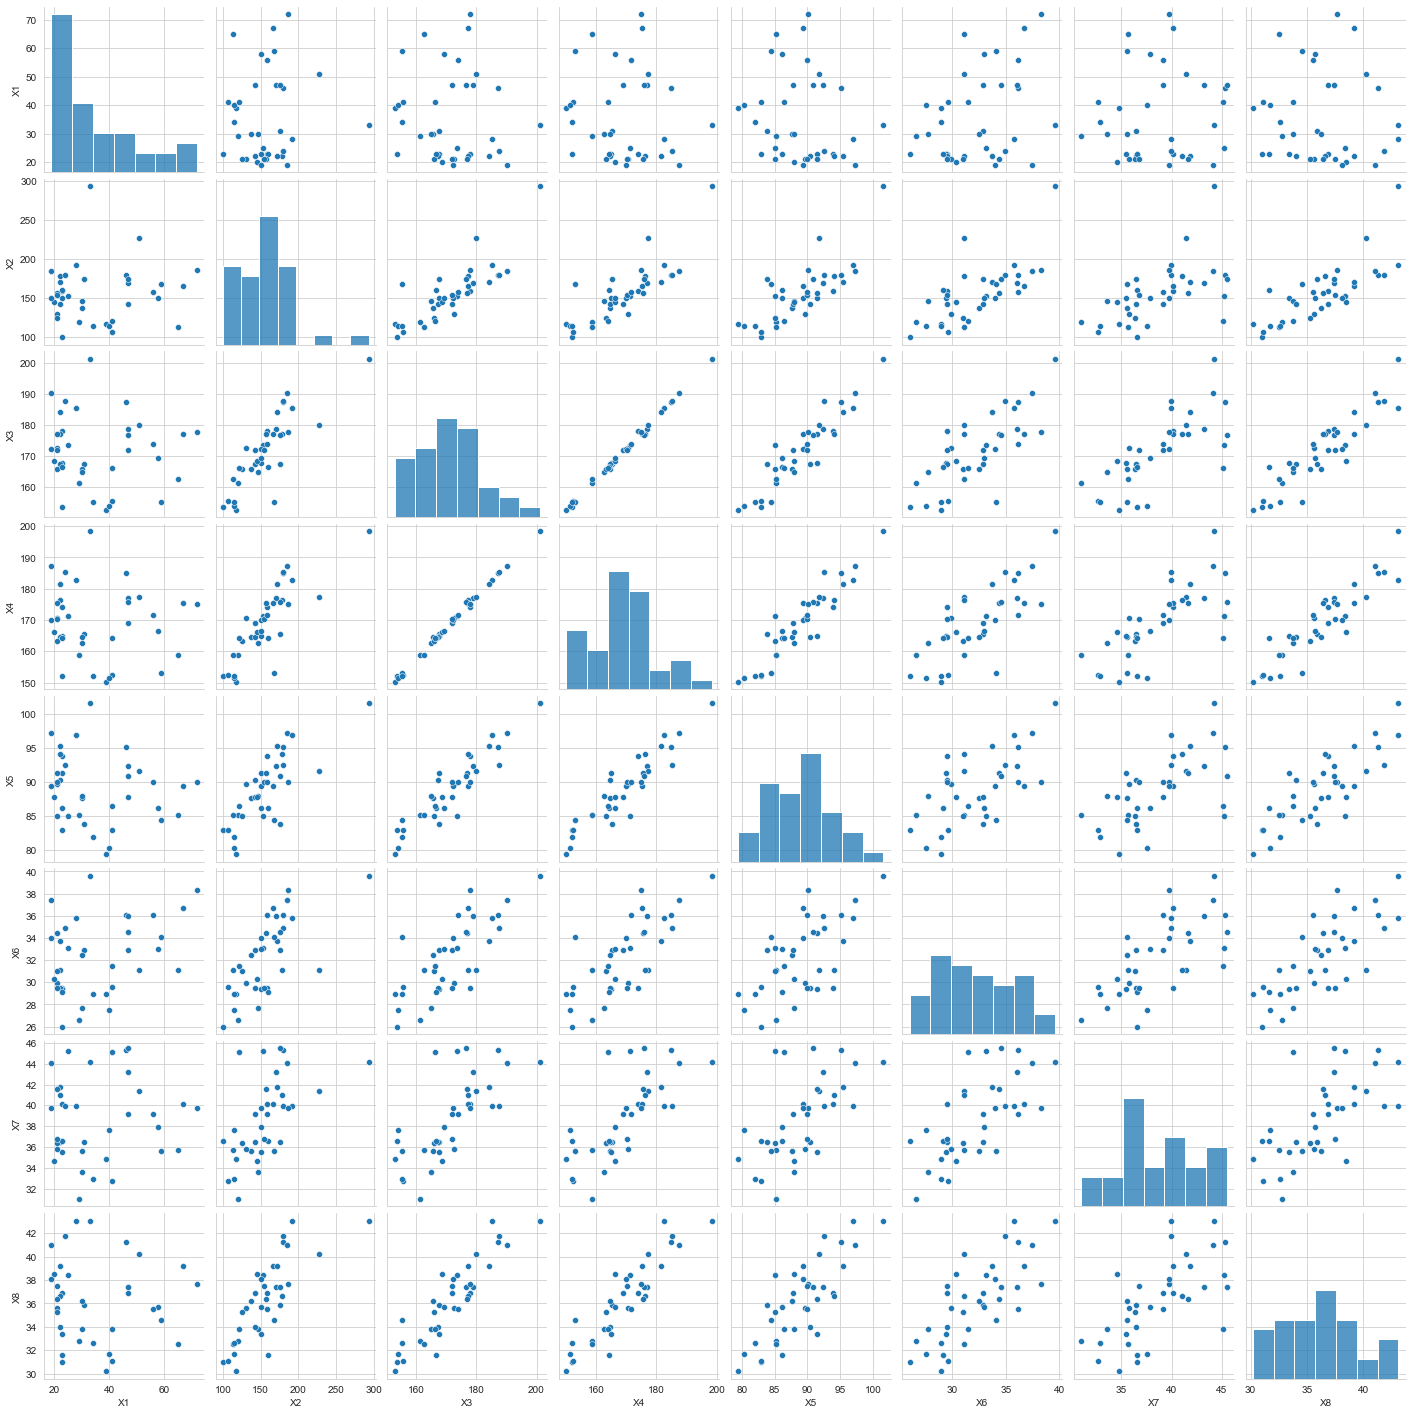

In [46]:
#### Solution
data = pd.read_csv("data.csv")
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]
sns.pairplot(data.iloc[:,:-1])
plt.show()

 <font color='green'>
    
#### Q2
The LASSO regression objective places a penalty on the size of the weight vector $\|\beta\|_1$. The coefficient $\beta_j$ assigned to feature $j$ will be affected by the magnitude of the feature. Therefore, a coefficient could be arbitrarily large if the feature values are arbitrarily large, even if that feature is not particularly important. To make the comparison across features less arbitrary, we standardize them all to be on the same scale.

In [28]:
#### Solution

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)

print(f"Feature Means: {scaled_X.mean(axis=0)}")               # all effectively equal to 0
print(f"Feature Variances: {scaled_X.var(axis=0)}")            # all effectively equal to 1

Feature Means: [-2.92163954e-17  2.85955470e-16 -1.60251929e-15  1.80411242e-16
  1.84501537e-15 -1.05179023e-16  9.71445147e-17 -1.23439271e-16]
Feature Variances: [1. 1. 1. 1. 1. 1. 1. 1.]


 <font color='green'>
    
#### Q3
Here I run the model for the various values of $\lambda$ and plot the Ridge path for each of the covariates in the model excluding the intercept. We can see that as $\lambda$ is made larger, the coefficients are shrunk towards zero as the optimisation method tries harder to satistfy the norm constraint. In particular, we can see that for very small values of $\lambda$, X3 and X4 had almost opposite coefficients, and as $\lambda$ is increased, they are given equal weight in the model. This is due to the nature of the 2 norm, which prefers to give uniform weight to variables that are interchangeable in the model, rather than remove one and keep the other as is the case with the 1-norm. These two variables are perfectly correlated so we see this effect much earlier. For the X5 variable, which is also strongly correlated, we see the model give all three variables uniform weight eventually. 

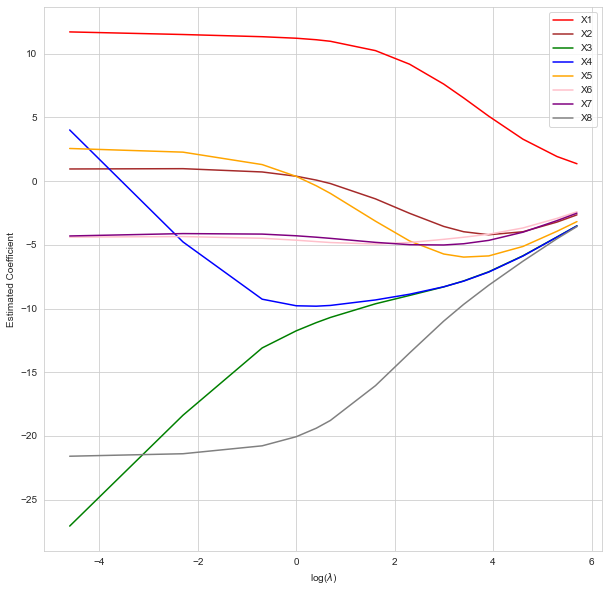

In [29]:
#### Solution

lambdas = [0.01,0.1,0.5,1,1.5, 2,5,10, 20, 30,50, 100, 200, 300]
N = len(lambdas)
coefs_mat = np.zeros((scaled_X.shape[1], N))
for i in range(N):
    L = lambdas[i]
    ridge_lm = Ridge(alpha=L).fit(scaled_X, Y)
    coefs_mat[:,i] = ridge_lm.coef_

colors = ['red', 'brown', 'green', 'blue', 'orange', 'pink', 'purple', 'grey']
plt.figure(figsize=(10,10))
for i in range(X.shape[1]):
    lab = "X" + str(i + 1)
    plt.plot(np.log(lambdas), coefs_mat[i], label=lab, color=colors[i])
    plt.legend()
plt.xlabel(r"log($\lambda$)")
plt.ylabel("Estimated Coefficient")
plt.show()

 <font color='green'>
    
#### Q4 
We see the optimal value in terms of lowest LOOCV score occuring for a choice of $\lambda =22.3.$ Obviously this is doing much better than OLS since OLS corresponds to the $\lambda=0$ case.

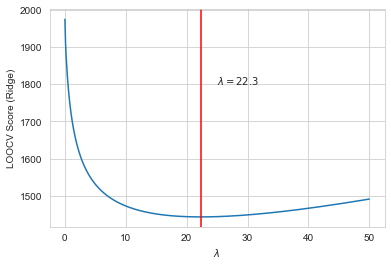

In [30]:
#### Solution

lambdas = np.arange(0, 50.1, step=0.1)
n = scaled_X.shape[0]
N = lambdas.shape[0]
CV_score = np.zeros(N)
curIdx = 0
Y = Y.to_numpy()
for L in lambdas:
    sq_errs = 0.
    for i in range(n):
        x_i = scaled_X[i]
        x_removed_i = np.delete(scaled_X, i, axis=0)      # dataset without i-th observation
        y_i = Y[i]
        y_removed_i = np.delete(Y, i, axis=0)

        mod = Ridge(alpha=L).fit(x_removed_i, y_removed_i)
        sq_errs += (mod.predict(x_i.reshape(1,-1))-y_i)**2

    CV_score[curIdx] = sq_errs/n
    curIdx += 1

min_idx = np.argmin(CV_score)
plt.plot(lambdas, CV_score)
plt.xlabel(r"$\lambda$")
plt.ylabel("LOOCV Score (Ridge)")
plt.axvline(x=lambdas[min_idx], color="red")
plt.annotate(f"$\lambda = {lambdas[min_idx]}$", xy=(25,1800))
plt.show()

 <font color='green'>
    
#### Q5
We see a similar pattern to the ridge case except that now the 1-norm penalty of the LASSO forces X4 to be zero and attached all weight to X3 since these two variables carry the same signal. In the ridge case the signal was spread uniformly across, but the LASSO prefers sparse solutions and so picks only one of them. The LASSO ends up setting all variables to zero as $\lambda$ is made to be increasingly large, something that does not happen in the Ridge case.

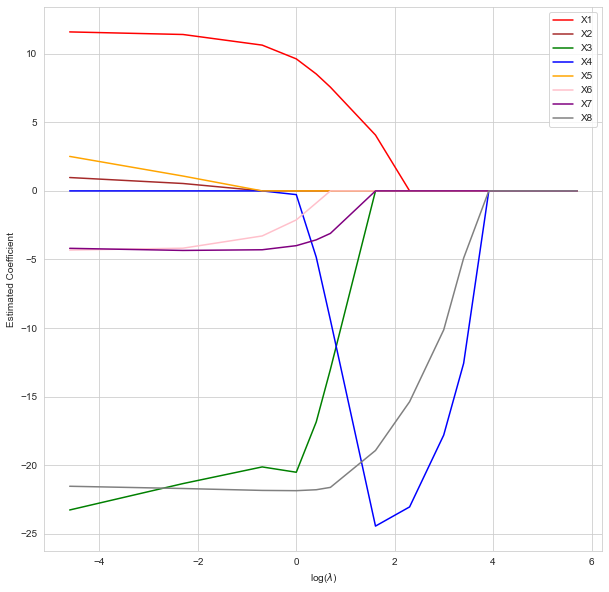

In [31]:
#### Solution

lambdas = [0.01,0.1,0.5,1,1.5, 2,5,10, 20, 30,50, 100, 200, 300]
N = len(lambdas)
coefs_mat = np.zeros((scaled_X.shape[1], N))
for i in range(N):
    L = lambdas[i]
    lasso_lm = Lasso(alpha=L).fit(scaled_X,Y)
    coefs_mat[:,i] = lasso_lm.coef_

colors = ['red', 'brown', 'green', 'blue', 'orange', 'pink', 'purple', 'grey']
plt.figure(figsize=(10,10))
for i in range(X.shape[1]):
    lab = "X" + str(i + 1)
    plt.plot(np.log(lambdas), coefs_mat[i], label=lab, color=colors[i])
    plt.legend()
plt.xlabel(r"log($\lambda$)")
plt.ylabel("Estimated Coefficient")
plt.show()

 <font color='green'>
    
#### Q6

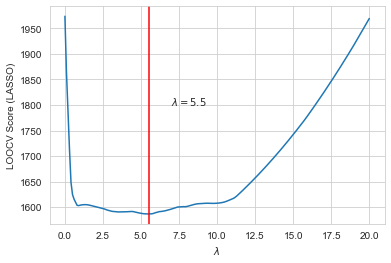

In [32]:
#### Solution

# throws a lot of annoying warnings for alpha=0.0 case, suppress them here
import warnings
warnings.filterwarnings("ignore")

lambdas = np.arange(0, 20.1, step=0.1)
n = scaled_X.shape[0]
N = lambdas.shape[0]
CV_score = np.zeros(N)
curIdx = 0
for L in lambdas:
    sq_errs = 0.
    for i in range(n):
        x_i = scaled_X[i]
        x_removed_i = np.delete(scaled_X, i, axis=0)      # dataset without i-th observation
        y_i = Y[i]
        y_removed_i = np.delete(Y, i, axis=0)

        mod = Lasso(alpha=L).fit(x_removed_i, y_removed_i, )
        sq_errs += (mod.predict(x_i.reshape(1,-1))-y_i)**2

    CV_score[curIdx] = sq_errs/n
    curIdx += 1

min_idx = np.argmin(CV_score)
plt.plot(lambdas, CV_score)
plt.xlabel(r"$\lambda$")
plt.ylabel("LOOCV Score (LASSO)")
plt.axvline(x=lambdas[min_idx], color="red")
plt.annotate(f"$\lambda = {lambdas[min_idx]}$", xy=(7,1800))
plt.show()

 <font color='green'>
    
#### Q7
If the goal is prediction, then ridge is the preferred choice given the LOO analysis. If the goal is inference (understanding the relationship between response and covariates), then the LASSO gives us a much simpler model.